In [ ]:
import os

def count_images_detailed(dataset_path):
    """
    Count images per split and per class
    """
    splits = ['Ftrain', 'Ftest', 'Fvalid']
    classes = ['autistic', 'non_autistic']

    print(" DETAILED IMAGE COUNTS:")
    print("=" * 40)

    for split in splits:
        split_path = os.path.join(dataset_path, split)

        if not os.path.exists(split_path):
            print(f" {split}: Folder not found")
            continue

        split_total = 0
        print(f"\n {split.upper()}:")

        # Check if organized by class folders
        has_class_folders = all(
            os.path.exists(os.path.join(split_path, class_name))
            for class_name in classes
        )

        if has_class_folders:
            # Count from class folders
            for class_name in classes:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    class_count = len([f for f in os.listdir(class_path)
                                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                    print(f"   ├── {class_name}: {class_count}")
                    split_total += class_count
        else:
            # Count all images in mixed folder
            image_count = 0
            for root, dirs, files in os.walk(split_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_count += 1
            split_total = image_count
            print(f"   ├── mixed: {image_count}")

        print(f"   └── TOTAL: {split_total}")

# Usage
dataset_path = "/content/drive/MyDrive/Colab Notebooks"
count_images_detailed(dataset_path)

📊 DETAILED IMAGE COUNTS:

📁 FTRAIN:
   ├── autistic: 3810
   ├── non_autistic: 3810
   └── TOTAL: 7620

📁 FTEST:
   ├── autistic: 150
   ├── non_autistic: 150
   └── TOTAL: 300

📁 FVALID:
   ├── autistic: 50
   ├── non_autistic: 50
   └── TOTAL: 100


In [ ]:
# ===============================================================
# SETUP: Installations & Imports
# ===============================================================
!pip install -q tensorflow scikit-learn matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import os
from datetime import datetime

print(" Libraries imported successfully!")
print(f" TensorFlow version: {tf.__version__}")

# Create results directory
os.makedirs('/content/drive/MyDrive/Colab Notebooks/training_results', exist_ok=True)

✅ Libraries imported successfully!
✅ TensorFlow version: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===============================================================
# 🔧 GPU VERIFICATION & OPTIMIZATION
# ===============================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import os
from datetime import datetime

print("🔍 CHECKING GPU AVAILABILITY...")
print("=" * 50)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU DETECTED: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"   GPU {i}: {gpu}")

    # Enable memory growth to avoid allocating all memory at once
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth: ENABLED")
    except RuntimeError as e:
        print(f"⚠️  Could not set memory growth: {e}")

else:
    print("❌ NO GPU DETECTED - Using CPU")
    print("⚠️  Training will be much slower on CPU!")

print("=" * 50)

# ===============================================================
# 📁 MOUNT GOOGLE DRIVE
# ===============================================================
from google.colab import drive
drive.mount('/content/drive')

# Create results directory
results_path = '/content/drive/MyDrive/Colab Notebooks/newDIP/training_results'
os.makedirs(results_path, exist_ok=True)

print(f"✅ Google Drive mounted!")
print(f"✅ Results will be saved to: {results_path}")

# ===============================================================
# 📊 LOAD YOUR ACTUAL DATASET
# ===============================================================

def load_actual_dataset():
    """
    Load your preprocessed images from the specified folders
    """
    print("📦 Loading your actual dataset...")

    # Your dataset paths
    train_path = '/content/drive/MyDrive/Colab Notebooks/Ftrain'
    valid_path = '/content/drive/MyDrive/Colab Notebooks/Fvalid'

    # Check if paths exist
    if not os.path.exists(train_path):
        raise Exception(f"❌ Training path not found: {train_path}")
    if not os.path.exists(valid_path):
        raise Exception(f"❌ Validation path not found: {valid_path}")

    print(f"📁 Training path: {train_path}")
    print(f"📁 Validation path: {valid_path}")

    # Use TensorFlow Data Generators (memory efficient)
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(160, 160),
        batch_size=16,
        class_mode='binary',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        valid_path,
        target_size=(160, 160),
        batch_size=16,
        class_mode='binary',
        shuffle=False
    )

    print(f"✅ Dataset loaded successfully!")
    print(f"   Training classes: {train_generator.class_indices}")
    print(f"   Training samples: {train_generator.samples}")
    print(f"   Validation samples: {val_generator.samples}")

    return train_generator, val_generator

# Load your actual dataset
train_generator, val_generator = load_actual_dataset()

# ===============================================================
# 🔄 DUAL INPUT GENERATOR (FIXED VERSION - TUPLES)
# ===============================================================

def dual_input_generator(generator):
    """
    Wraps a single generator to feed the same images to both model inputs.
    """
    while True:
        x, y = next(generator)
        yield (x, x), y  # ✅ Use TUPLE, not list

# Create dual input generators
train_gen_dual = dual_input_generator(train_generator)
val_gen_dual = dual_input_generator(val_generator)

print("✅ Dual input generators created!")

# ===============================================================
# 🧠 LIGHTWEIGHT ENSEMBLE MODEL
# ===============================================================

def create_lightweight_ensemble():
    from tensorflow.keras.applications import EfficientNetB0, DenseNet121
    from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, Dense, Dropout, BatchNormalization
    from tensorflow.keras.models import Model

    # Input layers
    input_effnet = Input(shape=(160, 160, 3), name='input_effnet')
    input_densenet = Input(shape=(160, 160, 3), name='input_densenet')

    # Base models (pre-trained, frozen)
    effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_effnet)
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_densenet)

    # Freeze base models
    effnet_base.trainable = False
    densenet_base.trainable = False

    # Feature extraction
    effnet_features = GlobalAveragePooling2D(name='effnet_gap')(effnet_base.output)
    densenet_features = GlobalAveragePooling2D(name='densenet_gap')(densenet_base.output)

    # Concatenate features
    combined = Concatenate(name='combined_features')([effnet_features, densenet_features])

    # Classification head
    dense_1 = Dense(128, activation='relu', name='dense_1')(combined)
    batch_norm_1 = BatchNormalization()(dense_1)
    dropout_1 = Dropout(0.3, name='dropout_1')(batch_norm_1)

    dense_2 = Dense(64, activation='relu', name='dense_2')(dropout_1)
    batch_norm_2 = BatchNormalization()(dense_2)
    dropout_2 = Dropout(0.3, name='dropout_2')(batch_norm_2)

    output = Dense(1, activation='sigmoid', name='output')(dropout_2)

    # Create model
    model = Model(inputs=[input_effnet, input_densenet], outputs=output, name='Lightweight_ASD_Ensemble')

    return model

print("🔄 Creating model on GPU...")
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    model = create_lightweight_ensemble()

# Simple compile (no custom metrics)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Lightweight Ensemble Model Created!")
print(f"✅ Total parameters: {model.count_params():,}")
print(f"✅ Model created on: {'GPU' if gpus else 'CPU'}")

# ===============================================================
# 💾 TRAINING HISTORY MANAGER
# ===============================================================

class TrainingHistory:
    def __init__(self):
        self.history = {
            'accuracy': [], 'loss': [],
            'val_accuracy': [], 'val_loss': [],
            'learning_rate': [], 'timestamps': [], 'epochs_completed': 0,
            'last_checkpoint': None
        }
        self.results_file = f'{results_path}/training_history.json'

    def update(self, new_history, epochs_trained, checkpoint_path=None):
        for key in self.history.keys():
            if key in new_history.history:
                self.history[key].extend(new_history.history[key])

        self.history['epochs_completed'] += epochs_trained
        self.history['timestamps'].append(datetime.now().isoformat())

        if checkpoint_path:
            self.history['last_checkpoint'] = checkpoint_path

        self.save()

    def save(self):
        with open(self.results_file, 'w') as f:
            json.dump(self.history, f, indent=2)
        print(f"💾 History saved: {self.results_file}")

    def load(self):
        if os.path.exists(self.results_file):
            with open(self.results_file, 'r') as f:
                self.history = json.load(f)
            print(f"📂 Loaded history: {self.history['epochs_completed']} epochs")

            if self.history['last_checkpoint'] and os.path.exists(self.history['last_checkpoint']):
                global model
                model = tf.keras.models.load_model(self.history['last_checkpoint'])
                print(f"🔄 Model loaded from: {self.history['last_checkpoint']}")
            return True
        return False

    def get_current_epoch(self):
        return self.history['epochs_completed']

    def print_latest_metrics(self):
        if self.history['accuracy']:
            print(f"📊 LATEST METRICS (Epoch {self.history['epochs_completed']}):")
            print(f"   Training   - Accuracy: {self.history['accuracy'][-1]:.4f}, Loss: {self.history['loss'][-1]:.4f}")
            if self.history['val_accuracy']:
                print(f"   Validation - Accuracy: {self.history['val_accuracy'][-1]:.4f}, Loss: {self.history['val_loss'][-1]:.4f}")

# Initialize history manager
history_manager = TrainingHistory()
history_manager.load()

# ===============================================================
# 🔄 ITERATIVE TRAINING WITH GPU MONITORING
# ===============================================================

def train_5_epochs():
    """
    Train for exactly 5 epochs with GPU monitoring
    """
    global model, history_manager

    current_epoch = history_manager.get_current_epoch()

    print(f"🚀 STARTING TRAINING: Epochs {current_epoch} to {current_epoch + 4}")
    print(f"💻 Using: {'GPU' if gpus else 'CPU'}")
    print("=" * 60)

    start_time = time.time()

    checkpoint_path = f'{results_path}/model_epoch_{current_epoch + 5}.h5'

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy', save_best_only=True, save_weights_only=False
        ),
        tf.keras.callbacks.CSVLogger(f'{results_path}/training_log.csv', append=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]

    try:
        # Train with explicit device context
        with tf.device('/GPU:0' if gpus else '/CPU:0'):
            history = model.fit(
                train_gen_dual,
                steps_per_epoch=train_generator.samples // train_generator.batch_size,
                epochs=current_epoch + 5,
                initial_epoch=current_epoch,
                validation_data=val_gen_dual,
                validation_steps=val_generator.samples // val_generator.batch_size,
                callbacks=callbacks,
                verbose=1
            )

        training_time = time.time() - start_time

        history_manager.update(history, epochs_trained=5, checkpoint_path=checkpoint_path)

        print(f"✅ TRAINING COMPLETED IN {training_time/60:.2f} minutes on {'GPU' if gpus else 'CPU'}!")
        history_manager.print_latest_metrics()

        return history

    except Exception as e:
        print(f"❌ TRAINING FAILED: {e}")
        return None

# ===============================================================
# 📈 PLOTTING FUNCTION
# ===============================================================

def plot_training_progress():
    history = history_manager.history

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    if history['accuracy']:
        plt.plot(history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
    if history['val_accuracy']:
        plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    if history['loss']:
        plt.plot(history['loss'], label='Training Loss', marker='o', linewidth=2)
    if history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{results_path}/training_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

print("🎯 SETUP COMPLETED!")
print(f"📁 Training data: {train_generator.samples} samples")
print(f"📁 Validation data: {val_generator.samples} samples")
print(f"💻 Training on: {'GPU' if gpus else 'CPU'}")
print(f"💾 Results will be saved to: {results_path}")

🔍 CHECKING GPU AVAILABILITY...
✅ GPU DETECTED: 1 GPU(s) available
   GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ GPU memory growth: ENABLED
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted!
✅ Results will be saved to: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results
📦 Loading your actual dataset...
📁 Training path: /content/drive/MyDrive/Colab Notebooks/Ftrain
📁 Validation path: /content/drive/MyDrive/Colab Notebooks/Fvalid
Found 7620 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
✅ Dataset loaded successfully!
   Training classes: {'autistic': 0, 'non_autistic': 1}
   Training samples: 7620
   Validation samples: 100
✅ Dual input generators created!
🔄 Creating model on GPU...
✅ Lightweight Ensemble Model Created!
✅ Total parameters: 11,391,204
✅ Model created on: GPU
🎯 SETUP COMPLETED!
📁 Training data: 7620 samples


 CURRENT TRAINING STATUS
 Epochs Completed: 15
 Dataset Info:
   Training samples: 7620
   Validation samples: 100
   Classes: {'autistic': 0, 'non_autistic': 1}
📊 LATEST METRICS (Epoch 15):
   Training   - Accuracy: 0.7904, Loss: 0.4432
   Validation - Accuracy: 0.6310, Loss: 0.6880


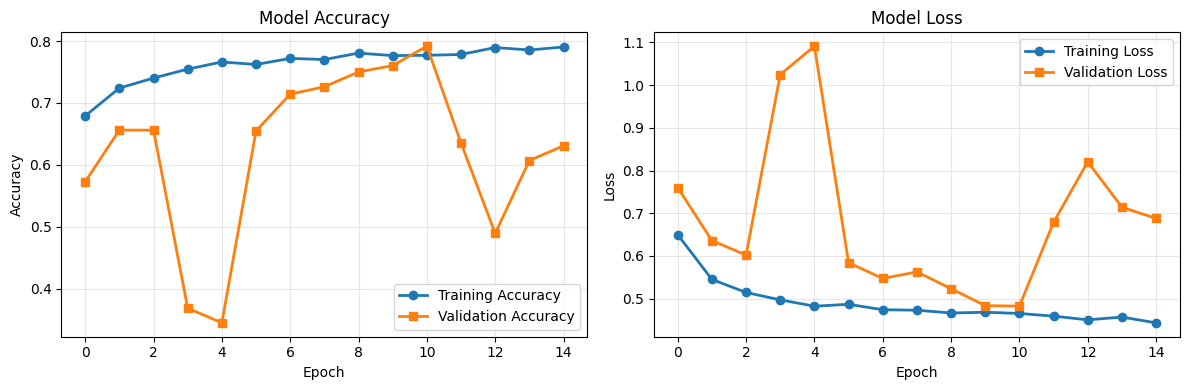

 Results saved in: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results


In [ ]:
# ===============================================================
#  CHECK CURRENT TRAINING STATUS
# ===============================================================

print(" CURRENT TRAINING STATUS")
print("=" * 40)

current_epoch = history_manager.get_current_epoch()
print(f" Epochs Completed: {current_epoch}")

print(f" Dataset Info:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Classes: {train_generator.class_indices}")

if current_epoch > 0:
    history_manager.print_latest_metrics()
    plot_training_progress()
else:
    print(" No training completed yet. Run Cell 2 to start training!")

print(f" Results saved in: {results_path}")

🚀 STARTING TRAINING: Epochs 0 to 4
💻 Using: GPU
Epoch 1/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6537 - loss: 0.7208

476/476 ━━━━━━━━━━━━━━━━━━━━ 1530s 3s/step - accuracy: 0.6538 - loss: 0.7206 - val_accuracy: 0.5729 - val_loss: 0.7601 - learning_rate: 0.0010
Epoch 2/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7216 - loss: 0.5460

476/476 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - accuracy: 0.7216 - loss: 0.5460 - val_accuracy: 0.6562 - val_loss: 0.6360 - learning_rate: 0.0010
Epoch 3/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 188ms/step - accuracy: 0.7391 - loss: 0.5150 - val_accuracy: 0.6562 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 4/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 101s 213ms/step - accuracy: 0.7607 - loss: 0.4941 - val_accuracy: 0.3690 - val_loss: 1.0249 - learning_rate: 0.0010
Epoch 5/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 88s 184ms/step - accuracy: 0.7665 - loss: 0.4785 - val_accuracy: 0.3452 - val_loss: 1.0914 - learning_rate: 0.0010
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 32.25 minutes on GPU!
📊 LATEST METRICS (Epoch 5):
   Training   - Accuracy: 0.7662, Loss: 0.4823
   Validation - Accuracy: 0.3452, Loss: 1.0914


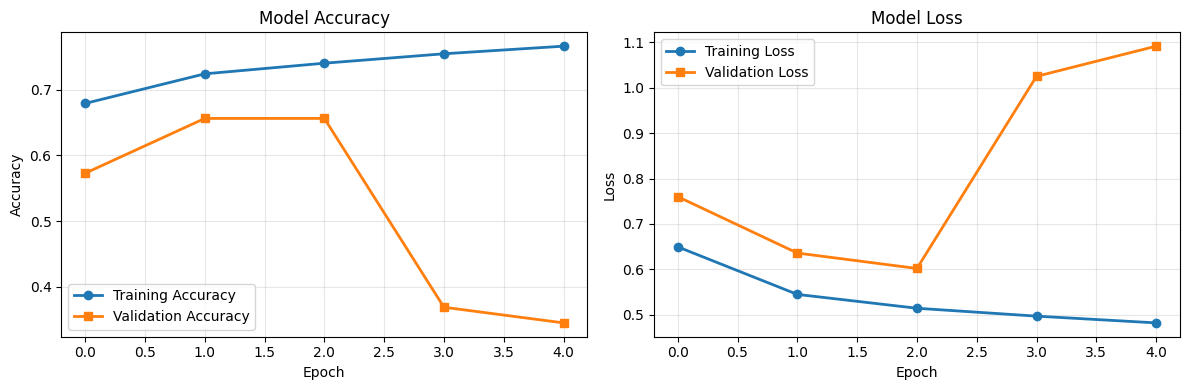

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 5 to 9
💻 Using: GPU
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7543 - loss: 0.4934

476/476 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - accuracy: 0.7543 - loss: 0.4934 - val_accuracy: 0.6548 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7653 - loss: 0.4756

476/476 ━━━━━━━━━━━━━━━━━━━━ 143s 301ms/step - accuracy: 0.7653 - loss: 0.4756 - val_accuracy: 0.7143 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7738 - loss: 0.4700

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 194ms/step - accuracy: 0.7738 - loss: 0.4700 - val_accuracy: 0.7262 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 9/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7743 - loss: 0.4701

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 194ms/step - accuracy: 0.7743 - loss: 0.4701 - val_accuracy: 0.7500 - val_loss: 0.5233 - learning_rate: 0.0010
Epoch 10/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7817 - loss: 0.4609

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.7817 - loss: 0.4610 - val_accuracy: 0.7604 - val_loss: 0.4836 - learning_rate: 0.0010
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 8.49 minutes on GPU!
📊 LATEST METRICS (Epoch 10):
   Training   - Accuracy: 0.7764, Loss: 0.4682
   Validation - Accuracy: 0.7604, Loss: 0.4836


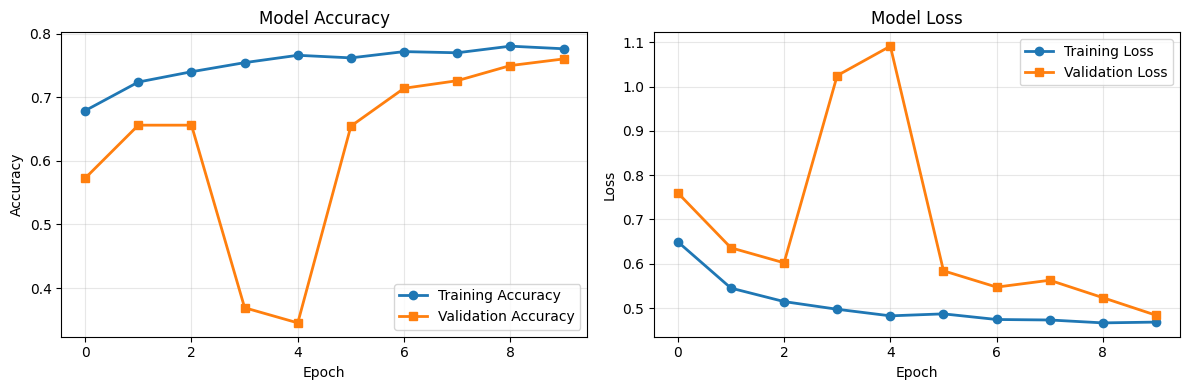

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 10 to 14
💻 Using: GPU
Epoch 11/15
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7813 - loss: 0.4610

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.7813 - loss: 0.4610 - val_accuracy: 0.7917 - val_loss: 0.4824 - learning_rate: 0.0010
Epoch 12/15
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.7890 - loss: 0.4444 - val_accuracy: 0.6354 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 13/15
476/476 ━━━━━━━━━━━━━━━━━━━━ 141s 298ms/step - accuracy: 0.8002 - loss: 0.4442 - val_accuracy: 0.4896 - val_loss: 0.8205 - learning_rate: 0.0010
Epoch 14/15
476/476 ━━━━━━━━━━━━━━━━━━━━ 90s 189ms/step - accuracy: 0.7940 - loss: 0.4481 - val_accuracy: 0.6071 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 15/15
476/476 ━━━━━━━━━━━━━━━━━━━━ 88s 185ms/step - accuracy: 0.7870 - loss: 0.4469 - val_accuracy: 0.6310 - val_loss: 0.6880 - learning_rate: 5.0000e-04
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 8.34 minutes on GPU!
📊 LATEST METRICS (Epoch 15):
   Training   - Accuracy: 0.7904, Loss: 0.4432
   V

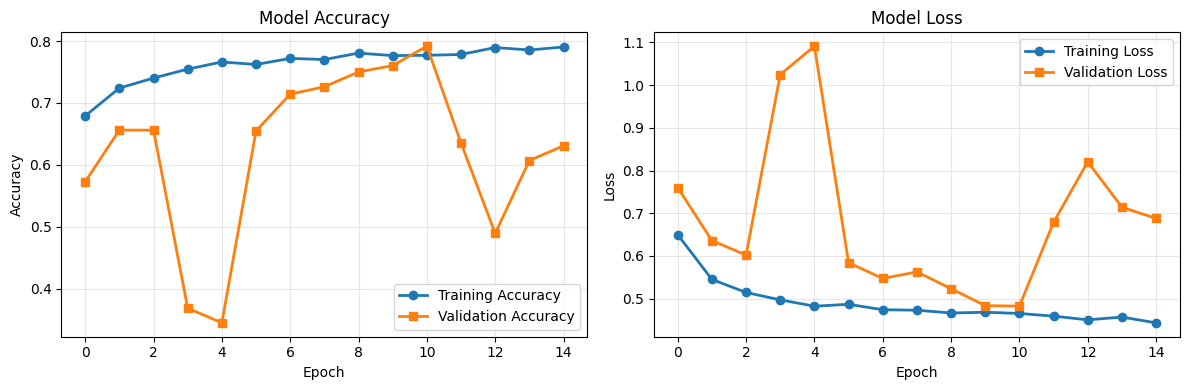

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 15 to 19
💻 Using: GPU
Epoch 16/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7869 - loss: 0.4444

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.7870 - loss: 0.4444 - val_accuracy: 0.7976 - val_loss: 0.4358 - learning_rate: 5.0000e-04
Epoch 17/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.8010 - loss: 0.4345 - val_accuracy: 0.7976 - val_loss: 0.4104 - learning_rate: 5.0000e-04
Epoch 18/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.8033 - loss: 0.4282 - val_accuracy: 0.7976 - val_loss: 0.4005 - learning_rate: 5.0000e-04
Epoch 19/20
475/476 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8045 - loss: 0.4268

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 194ms/step - accuracy: 0.8045 - loss: 0.4268 - val_accuracy: 0.8958 - val_loss: 0.3329 - learning_rate: 5.0000e-04
Epoch 20/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 90s 189ms/step - accuracy: 0.7980 - loss: 0.4316 - val_accuracy: 0.8125 - val_loss: 0.4238 - learning_rate: 5.0000e-04
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 7.52 minutes on GPU!
📊 LATEST METRICS (Epoch 20):
   Training   - Accuracy: 0.7971, Loss: 0.4312
   Validation - Accuracy: 0.8125, Loss: 0.4238


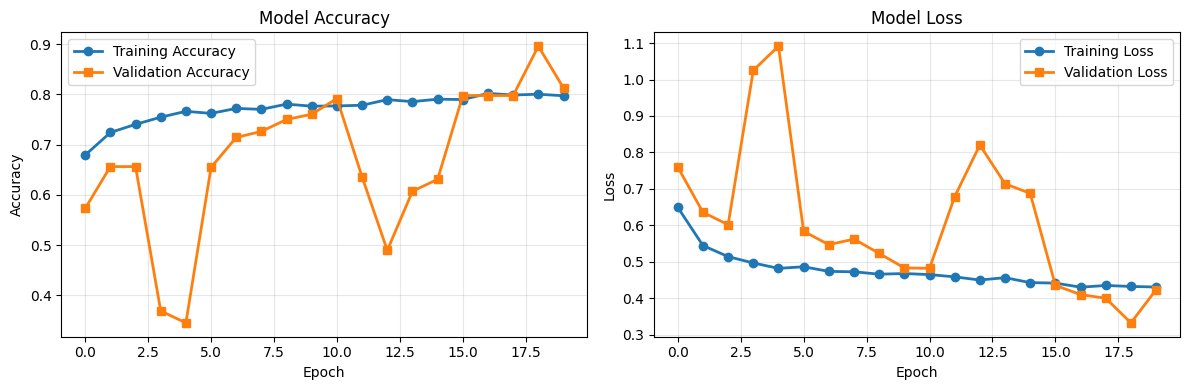

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 20 to 24
💻 Using: GPU
Epoch 21/25
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8001 - loss: 0.4275

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.8001 - loss: 0.4275 - val_accuracy: 0.8095 - val_loss: 0.4300 - learning_rate: 5.0000e-04
Epoch 22/25
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.7976 - loss: 0.4368 - val_accuracy: 0.7619 - val_loss: 0.5028 - learning_rate: 5.0000e-04
Epoch 23/25
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 188ms/step - accuracy: 0.8075 - loss: 0.4228 - val_accuracy: 0.7500 - val_loss: 0.4714 - learning_rate: 5.0000e-04
Epoch 24/25
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.8072 - loss: 0.4135 - val_accuracy: 0.6806 - val_loss: 0.6666 - learning_rate: 5.0000e-04
Epoch 25/25
476/476 ━━━━━━━━━━━━━━━━━━━━ 88s 185ms/step - accuracy: 0.8156 - loss: 0.4146 - val_accuracy: 0.7778 - val_loss: 0.5113 - learning_rate: 2.5000e-04
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 7.45 minutes on GPU!
📊 LATEST METRICS (Epoch 25):
   Training   - Accuracy: 0.8098, Lo

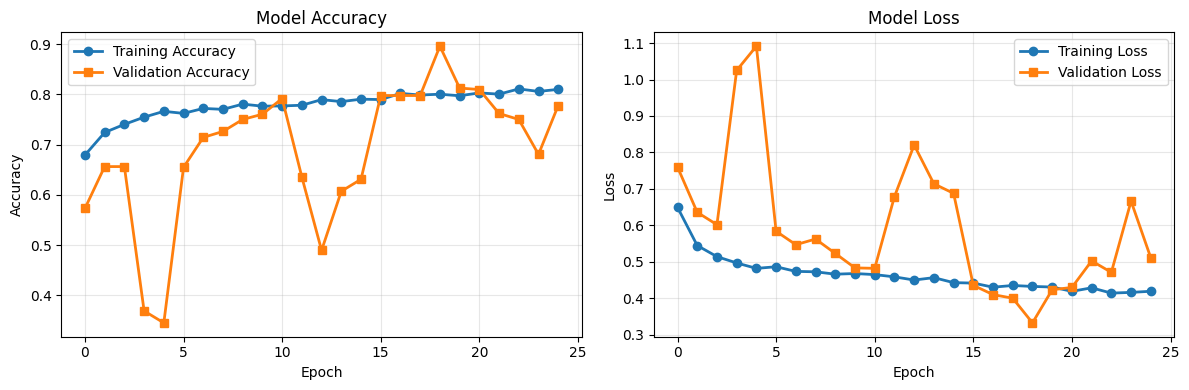

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 25 to 29
💻 Using: GPU
Epoch 26/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8164 - loss: 0.4094

476/476 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - accuracy: 0.8164 - loss: 0.4094 - val_accuracy: 0.7976 - val_loss: 0.4155 - learning_rate: 2.5000e-04
Epoch 27/30
475/476 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8150 - loss: 0.4026

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 193ms/step - accuracy: 0.8150 - loss: 0.4026 - val_accuracy: 0.8452 - val_loss: 0.3438 - learning_rate: 2.5000e-04
Epoch 28/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 139s 292ms/step - accuracy: 0.8056 - loss: 0.4189 - val_accuracy: 0.8125 - val_loss: 0.3668 - learning_rate: 2.5000e-04
Epoch 29/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 87s 184ms/step - accuracy: 0.8243 - loss: 0.4077 - val_accuracy: 0.8021 - val_loss: 0.3855 - learning_rate: 2.5000e-04
Epoch 30/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 186ms/step - accuracy: 0.8180 - loss: 0.3955 - val_accuracy: 0.7708 - val_loss: 0.5025 - learning_rate: 2.5000e-04
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 8.29 minutes on GPU!
📊 LATEST METRICS (Epoch 30):
   Training   - Accuracy: 0.8137, Loss: 0.4039
   Validation - Accuracy: 0.7708, Loss: 0.5025


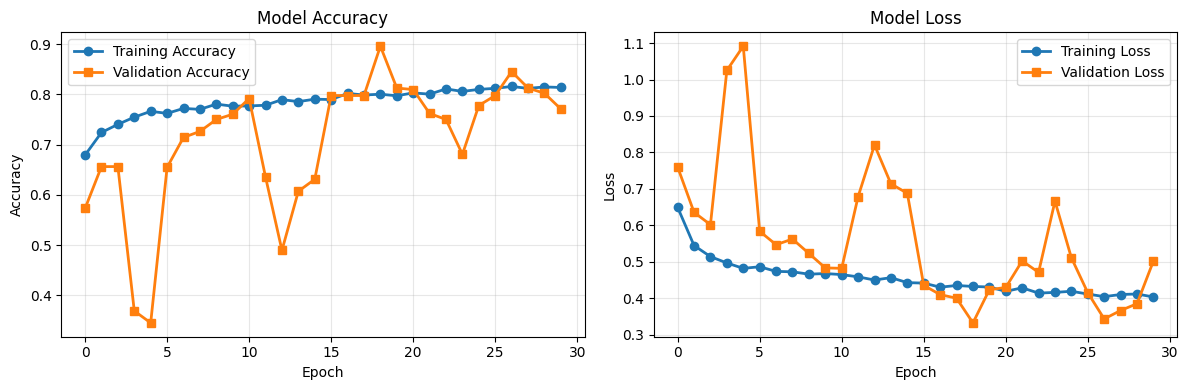

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 30 to 34
💻 Using: GPU
Epoch 31/35
475/476 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8142 - loss: 0.4024

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.8143 - loss: 0.4024 - val_accuracy: 0.7976 - val_loss: 0.4706 - learning_rate: 1.2500e-04
Epoch 32/35
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8143 - loss: 0.4059

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 193ms/step - accuracy: 0.8143 - loss: 0.4059 - val_accuracy: 0.8056 - val_loss: 0.4573 - learning_rate: 1.2500e-04
Epoch 33/35
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8209 - loss: 0.3841

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 194ms/step - accuracy: 0.8209 - loss: 0.3841 - val_accuracy: 0.8194 - val_loss: 0.4847 - learning_rate: 1.2500e-04
Epoch 34/35
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8121 - loss: 0.4074

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 194ms/step - accuracy: 0.8121 - loss: 0.4074 - val_accuracy: 0.8472 - val_loss: 0.3969 - learning_rate: 1.2500e-04
Epoch 35/35
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8182 - loss: 0.3969

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 193ms/step - accuracy: 0.8182 - loss: 0.3969 - val_accuracy: 0.8750 - val_loss: 0.3096 - learning_rate: 1.2500e-04
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 7.66 minutes on GPU!
📊 LATEST METRICS (Epoch 35):
   Training   - Accuracy: 0.8161, Loss: 0.3981
   Validation - Accuracy: 0.8750, Loss: 0.3096


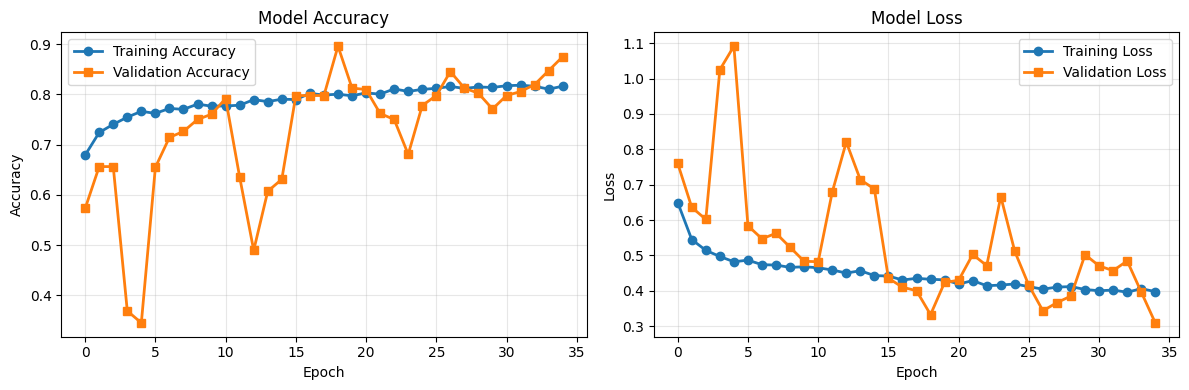

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 35 to 39
💻 Using: GPU
Epoch 36/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8185 - loss: 0.3900

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 191ms/step - accuracy: 0.8185 - loss: 0.3900 - val_accuracy: 0.8095 - val_loss: 0.4262 - learning_rate: 1.2500e-04
Epoch 37/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8133 - loss: 0.4097

476/476 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.8133 - loss: 0.4096 - val_accuracy: 0.8452 - val_loss: 0.3569 - learning_rate: 1.2500e-04
Epoch 38/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 186ms/step - accuracy: 0.8135 - loss: 0.3990 - val_accuracy: 0.8333 - val_loss: 0.3746 - learning_rate: 1.2500e-04
Epoch 39/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.8098 - loss: 0.4113 - val_accuracy: 0.8125 - val_loss: 0.4047 - learning_rate: 1.2500e-04
Epoch 40/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 88s 185ms/step - accuracy: 0.8193 - loss: 0.3988 - val_accuracy: 0.7812 - val_loss: 0.4633 - learning_rate: 1.2500e-04
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 7.47 minutes on GPU!
📊 LATEST METRICS (Epoch 40):
   Training   - Accuracy: 0.8185, Loss: 0.4010
   Validation - Accuracy: 0.7812, Loss: 0.4633


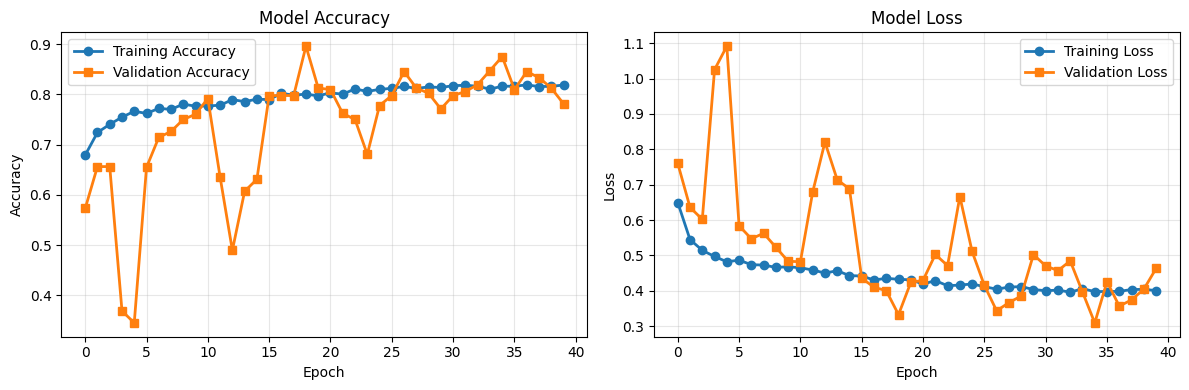

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

🚀 STARTING TRAINING: Epochs 40 to 44
💻 Using: GPU
Epoch 41/45
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8149 - loss: 0.4057

476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 188ms/step - accuracy: 0.8149 - loss: 0.4057 - val_accuracy: 0.8095 - val_loss: 0.4645 - learning_rate: 6.2500e-05
Epoch 42/45
476/476 ━━━━━━━━━━━━━━━━━━━━ 89s 186ms/step - accuracy: 0.8271 - loss: 0.3830 - val_accuracy: 0.8056 - val_loss: 0.4575 - learning_rate: 6.2500e-05
Epoch 43/45
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8170 - loss: 0.3977

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 194ms/step - accuracy: 0.8171 - loss: 0.3977 - val_accuracy: 0.8194 - val_loss: 0.4664 - learning_rate: 6.2500e-05
Epoch 44/45
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8248 - loss: 0.3922

476/476 ━━━━━━━━━━━━━━━━━━━━ 92s 193ms/step - accuracy: 0.8248 - loss: 0.3922 - val_accuracy: 0.8750 - val_loss: 0.3876 - learning_rate: 6.2500e-05
Epoch 45/45
476/476 ━━━━━━━━━━━━━━━━━━━━ 138s 291ms/step - accuracy: 0.8151 - loss: 0.3976 - val_accuracy: 0.8750 - val_loss: 0.3296 - learning_rate: 6.2500e-05
💾 History saved: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_history.json
✅ TRAINING COMPLETED IN 8.34 minutes on GPU!
📊 LATEST METRICS (Epoch 45):
   Training   - Accuracy: 0.8163, Loss: 0.3993
   Validation - Accuracy: 0.8750, Loss: 0.3296


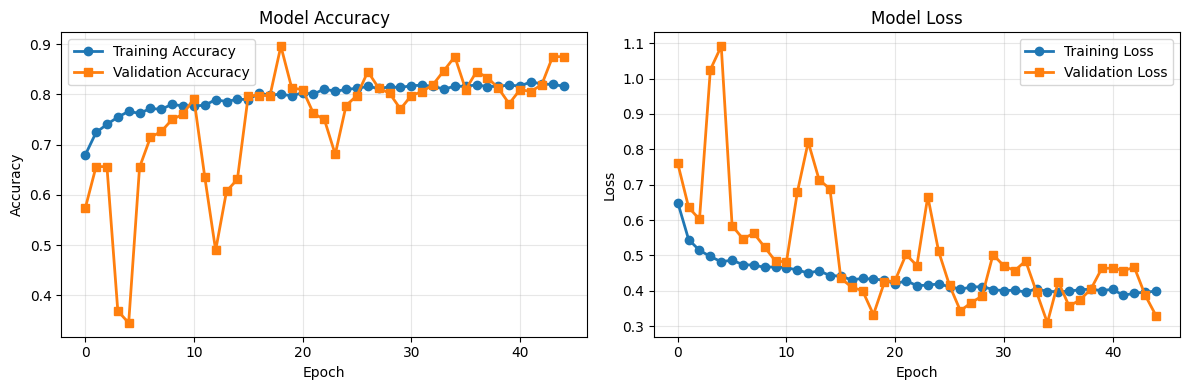

 Run this cell again to train another 5 epochs!
All results automatically saved to Google Drive!


In [ ]:
# ===============================================================
#  TRAIN FOR 5 EPOCHS (FIXED - Run this multiple times)
# ===============================================================

# Train for 5 epochs
history = train_5_epochs()

if history is not None:
    # Show updated progress
    plot_training_progress()
    print(" Run this cell again to train another 5 epochs!")
else:
    print(" Training failed. Check memory usage and try smaller batch size.")

print("All results automatically saved to Google Drive!")

In [ ]:
# ===============================================================
# 📈 FIND MAXIMUM ACCURACIES FROM TRAINING LOG
# ===============================================================

import pandas as pd
import numpy as np

def analyze_training_log(log_path='/content/drive/MyDrive/Colab Notebooks/newDIP/training_results/training_log.csv'):
    """
    Analyze training log to find maximum accuracies and their epochs
    """
    print("📊 ANALYZING TRAINING LOG...")
    print("=" * 50)

    try:
        # Load the training log
        df = pd.read_csv(log_path)

        print(f"✅ Loaded training log with {len(df)} epochs")
        print(f"📋 Available columns: {list(df.columns)}")

        # Check which columns are available
        accuracy_col = 'accuracy' if 'accuracy' in df.columns else None
        val_accuracy_col = 'val_accuracy' if 'val_accuracy' in df.columns else None

        if not accuracy_col or not val_accuracy_col:
            print("❌ Required columns not found in log file")
            return

        # Find maximum values and their epochs
        max_train_acc = df[accuracy_col].max()
        max_train_epoch = df[accuracy_col].idxmax() + 1  # +1 because epochs start at 1

        max_val_acc = df[val_accuracy_col].max()
        max_val_epoch = df[val_accuracy_col].idxmax() + 1

        # Find the epoch where BOTH are highest (balanced performance)
        df['combined_score'] = df[accuracy_col] + df[val_accuracy_col]
        best_combined_epoch = df['combined_score'].idxmax() + 1
        best_combined_train = df.loc[best_combined_epoch-1, accuracy_col]
        best_combined_val = df.loc[best_combined_epoch-1, val_accuracy_col]

        print("🎯 MAXIMUM ACCURACIES FOUND:")
        print(f"   🏆 Maximum Training Accuracy: {max_train_acc:.4f} (Epoch {max_train_epoch})")
        print(f"   🏆 Maximum Validation Accuracy: {max_val_acc:.4f} (Epoch {max_val_epoch})")
        print(f"   ⚖️  Best Balanced Epoch: {best_combined_epoch}")
        print(f"      - Training Accuracy: {best_combined_train:.4f}")
        print(f"      - Validation Accuracy: {best_combined_val:.4f}")

        # Calculate gaps
        gap_at_max_train = max_train_acc - df.loc[max_train_epoch-1, val_accuracy_col]
        gap_at_max_val = df.loc[max_val_epoch-1, accuracy_col] - max_val_acc

        print(f"\n📊 PERFORMANCE GAPS:")
        print(f"   At max training accuracy: {gap_at_max_train:+.4f}")
        print(f"   At max validation accuracy: {gap_at_max_val:+.4f}")

        # Latest epoch performance
        latest_epoch = len(df)
        latest_train = df[accuracy_col].iloc[-1]
        latest_val = df[val_accuracy_col].iloc[-1]
        latest_gap = latest_train - latest_val

        print(f"\n📅 LATEST EPOCH ({latest_epoch}):")
        print(f"   Training Accuracy: {latest_train:.4f}")
        print(f"   Validation Accuracy: {latest_val:.4f}")
        print(f"   Gap: {latest_gap:+.4f}")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        if abs(latest_gap) > 0.15:
            print("   ⚠️  Large gap detected - potential overfitting/underfitting")
        elif latest_gap < 0:
            print("   ✅ Validation > Training - Good generalization!")
        else:
            print("   ✅ Reasonable gap - Continue training")

        if max_val_epoch < latest_epoch - 5:
            print("   📉 Validation accuracy peaked earlier - consider early stopping")

        return df, max_train_epoch, max_val_epoch, best_combined_epoch

    except Exception as e:
        print(f"❌ Error analyzing training log: {e}")
        return None

# Run the analysis
results = analyze_training_log()

📊 ANALYZING TRAINING LOG...
✅ Loaded training log with 45 epochs
📋 Available columns: ['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss']
🎯 MAXIMUM ACCURACIES FOUND:
   🏆 Maximum Training Accuracy: 0.8250 (Epoch 42)
   🏆 Maximum Validation Accuracy: 0.8958 (Epoch 19)
   ⚖️  Best Balanced Epoch: 19
      - Training Accuracy: 0.8002
      - Validation Accuracy: 0.8958

📊 PERFORMANCE GAPS:
   At max training accuracy: +0.0194
   At max validation accuracy: -0.0956

📅 LATEST EPOCH (45):
   Training Accuracy: 0.8163
   Validation Accuracy: 0.8750
   Gap: -0.0587

💡 RECOMMENDATIONS:
   ✅ Validation > Training - Good generalization!
   📉 Validation accuracy peaked earlier - consider early stopping


MODEL ENSEMBLING EVALUATION WITH COMPREHENSIVE METRICS
Found 300 images belonging to 2 classes.
Test dataset loaded: 300 samples
Classes: {'autistic': 0, 'non_autistic': 1}

3. MODEL ENSEMBLING WITH DEFAULT THRESHOLD (0.5)
Found 9 model files


   Epoch 10: model_epoch_10.h5


   Epoch 15: model_epoch_15.h5


   Epoch 20: model_epoch_20.h5


   Epoch 25: model_epoch_25.h5


   Epoch 30: model_epoch_30.h5


   Epoch 35: model_epoch_35.h5


   Epoch 40: model_epoch_40.h5


   Epoch 45: model_epoch_45.h5


   Epoch  5: model_epoch_5.h5
Using 3 models for ensemble:
   - Epoch 45
   - Epoch 40
   - Epoch 35
Making ensemble predictions...
   Processed 5/19 batches...
   Processed 10/19 batches...
   Processed 15/19 batches...

Ensemble (Default Threshold) - COMPREHENSIVE METRICS:
------------------------------------------------------------
Accuracy:          0.7867 (78.67%)
ROC AUC:           0.8726
PR AUC:            0.8853
Sensitivity:       0.8533
Specificity:       0.7200
Precision:         0.7529
F1-Score:          0.8000
Threshold Used:    0.5
Confusion Matrix:  TN=108, FP=42, FN=22, TP=128


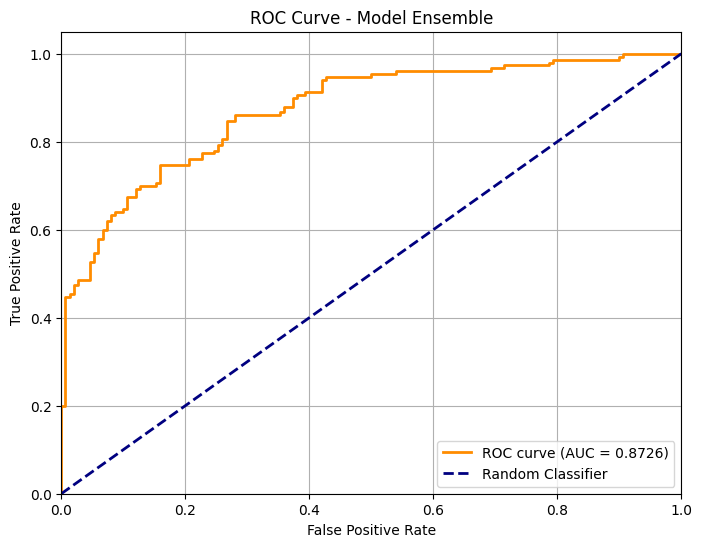

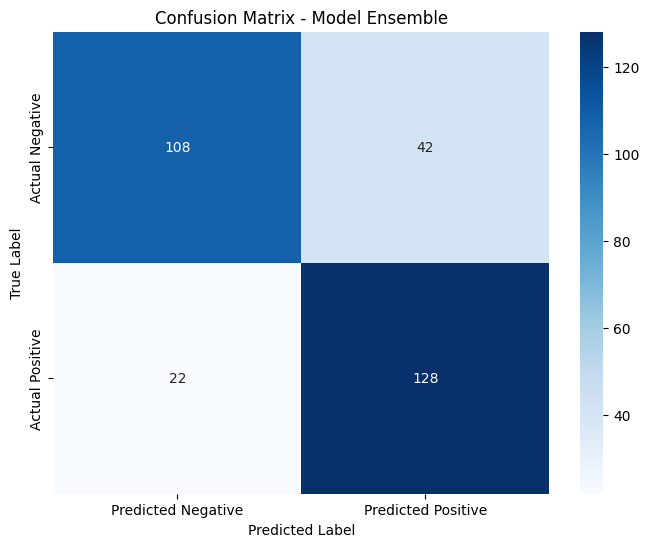


CLASSIFICATION REPORT - Ensemble:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77       150
         1.0       0.75      0.85      0.80       150

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300

Saved ensemble results to: /content/drive/MyDrive/Colab Notebooks/newDIP/training_results/ensemble_results.json

ENSEMBLE PERFORMANCE SUMMARY:
Accuracy:    0.7867 (78.67%)
ROC AUC:     0.8726
F1-Score:    0.8000
Sensitivity: 0.8533
Specificity: 0.7200


In [ ]:
import tensorflow as tf
import numpy as np
import os
import json
from datetime import datetime
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("MODEL ENSEMBLING EVALUATION WITH COMPREHENSIVE METRICS")
print("=" * 70)

# Define paths
test_path = '/content/drive/MyDrive/Colab Notebooks/Ftest'
results_path = '/content/drive/MyDrive/Colab Notebooks/newDIP/training_results'

# Load test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(160, 160),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

print(f"Test dataset loaded: {test_generator.samples} samples")
print(f"Classes: {test_generator.class_indices}")

def calculate_comprehensive_metrics(y_true, y_pred_proba, y_pred_binary, strategy_name):
    """Calculate comprehensive evaluation metrics using default threshold (0.5)"""

    # Basic metrics
    accuracy = np.mean(y_true == y_pred_binary)

    # ROC curve metrics
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve metrics
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    # Classification report
    report = classification_report(y_true, y_pred_binary, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)

    # Additional metrics
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_metric = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision_metric * sensitivity) / (precision_metric + sensitivity) if (precision_metric + sensitivity) > 0 else 0

    metrics = {
        'strategy': strategy_name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_metric,
        'f1_score': f1_score,
        'confusion_matrix': cm.tolist(),
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'threshold_used': 0.5,
        'timestamp': datetime.now().isoformat()
    }

    return metrics, fpr, tpr, precision, recall

def plot_roc_curve(fpr, tpr, roc_auc, strategy_name):
    """Plot ROC curve"""
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {strategy_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve(precision, recall, pr_auc, strategy_name):
    """Plot Precision-Recall curve"""
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'Precision-Recall Curve - {strategy_name}')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, strategy_name):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - {strategy_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_detailed_metrics(metrics):
    """Print detailed evaluation metrics"""
    print(f"\n{metrics['strategy']} - COMPREHENSIVE METRICS:")
    print("-" * 60)
    print(f"Accuracy:          {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"ROC AUC:           {metrics['roc_auc']:.4f}")
    print(f"PR AUC:            {metrics['pr_auc']:.4f}")
    print(f"Sensitivity:       {metrics['sensitivity']:.4f}")
    print(f"Specificity:       {metrics['specificity']:.4f}")
    print(f"Precision:         {metrics['precision']:.4f}")
    print(f"F1-Score:          {metrics['f1_score']:.4f}")
    print(f"Threshold Used:    {metrics['threshold_used']}")
    print(f"Confusion Matrix:  TN={metrics['true_negatives']}, FP={metrics['false_positives']}, FN={metrics['false_negatives']}, TP={metrics['true_positives']}")

# ===============================================================
# STRATEGY 3: MODEL ENSEMBLING (DEFAULT THRESHOLD 0.5)
# ===============================================================

print("\n3. MODEL ENSEMBLING WITH DEFAULT THRESHOLD (0.5)")
print("=" * 50)

def create_honest_ensemble():
    """Create ensemble using available models"""

    model_files = [f for f in os.listdir(results_path) if f.endswith('.h5') and 'epoch' in f]
    available_models = []

    print(f"Found {len(model_files)} model files")

    for model_file in sorted(model_files):
        try:
            epoch_num = int(''.join(filter(str.isdigit, model_file.split('_')[-1].split('.')[0])))
            model_path = os.path.join(results_path, model_file)
            model_instance = tf.keras.models.load_model(model_path)
            available_models.append((epoch_num, model_instance, model_path))
            print(f"   Epoch {epoch_num:2d}: {model_file}")
        except Exception as e:
            print(f"   Failed to load {model_file}: {e}")
            continue

    if len(available_models) < 2:
        print("Not enough models for ensemble (need at least 2)")
        return None

    # Use top 3 models by epoch
    available_models.sort(key=lambda x: x[0], reverse=True)
    ensemble_models = available_models[:min(3, len(available_models))]

    print(f"Using {len(ensemble_models)} models for ensemble:")
    for epoch, model, path in ensemble_models:
        print(f"   - Epoch {epoch}")

    return ensemble_models

def ensemble_predict_honest(ensemble_models, test_generator):
    """Ensemble predictions using default threshold"""

    test_generator.reset()
    y_true_ensemble = []
    y_pred_proba_ensemble = []

    total_batches = len(test_generator)

    print("Making ensemble predictions...")
    for batch_idx in range(total_batches):
        X, y = next(test_generator)

        model_predictions = []
        for epoch, model, path in ensemble_models:
            pred = model.predict([X, X], verbose=0)
            model_predictions.append(pred.flatten())

        # Equal weighting for honest evaluation
        avg_pred = np.mean(model_predictions, axis=0)

        y_true_ensemble.extend(y)
        y_pred_proba_ensemble.extend(avg_pred)

        if (batch_idx + 1) % 5 == 0:
            print(f"   Processed {batch_idx + 1}/{total_batches} batches...")

    y_true_ensemble = np.array(y_true_ensemble)
    y_pred_proba_ensemble = np.array(y_pred_proba_ensemble)
    y_pred_binary_ensemble = (y_pred_proba_ensemble > 0.5).astype(int)  # Default threshold

    return y_true_ensemble, y_pred_proba_ensemble, y_pred_binary_ensemble

# Create ensemble and make predictions
ensemble_models = create_honest_ensemble()
if ensemble_models:
    y_true_ensemble, y_pred_proba_ensemble, y_pred_binary_ensemble = ensemble_predict_honest(ensemble_models, test_generator)

    # Calculate comprehensive metrics
    ensemble_metrics, fpr, tpr, precision, recall = calculate_comprehensive_metrics(
        y_true_ensemble, y_pred_proba_ensemble, y_pred_binary_ensemble, "Ensemble (Default Threshold)"
    )

    # Print detailed metrics
    print_detailed_metrics(ensemble_metrics)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, ensemble_metrics['roc_auc'], "Model Ensemble")

    # Plot confusion matrix
    plot_confusion_matrix(np.array(ensemble_metrics['confusion_matrix']), "Model Ensemble")

    # Print classification report
    print(f"\nCLASSIFICATION REPORT - Ensemble:")
    print("-" * 50)
    report = classification_report(y_true_ensemble, y_pred_binary_ensemble)
    print(report)

    # Save results
    def save_ensemble_results(metrics):
        results_data = {
            'strategy': metrics['strategy'],
            'evaluation_metrics': metrics,
            'methodology': 'Honest evaluation with default threshold (0.5)',
            'test_set_size': len(y_true_ensemble),
            'timestamp': datetime.now().isoformat(),
            'classes': test_generator.class_indices,
            'ensemble_models_used': [f"Epoch {epoch}" for epoch, _, _ in ensemble_models]
        }

        filename = f'{results_path}/ensemble_results.json'
        with open(filename, 'w') as f:
            json.dump(results_data, f, indent=2)

        print(f"Saved ensemble results to: {filename}")

    save_ensemble_results(ensemble_metrics)

    # Performance summary
    print(f"\nENSEMBLE PERFORMANCE SUMMARY:")
    print("=" * 50)
    print(f"Accuracy:    {ensemble_metrics['accuracy']:.4f} ({ensemble_metrics['accuracy']*100:.2f}%)")
    print(f"ROC AUC:     {ensemble_metrics['roc_auc']:.4f}")
    print(f"F1-Score:    {ensemble_metrics['f1_score']:.4f}")
    print(f"Sensitivity: {ensemble_metrics['sensitivity']:.4f}")
    print(f"Specificity: {ensemble_metrics['specificity']:.4f}")
